In [1]:
################################################
#### Jingying Wang <astro.jywang@gmail.com> ####
###############################################

#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
plot_gsize=90
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb

# Select an observation block and load basic information in


In [2]:
#select an observation block

#fname='1551037708'  #3c237 
#fname='1551055211'  #rfi
#fname='1553966342'  #rfi
fname='1554156377'  #diode noise in one dump ##rfi clean
#fname='1556138397'  #rfi spots structure, only one so ok
#fname='1555775533'  #vis<1 and structure
#fname='1555793534'  #vis<1 and rfi pollution
#fname='1556120503'  #strong rfi spots in line
#fname='1556052116'  #good one, vis < 10
#fname='1556034219'  #strong rfi spots
#fname='1555879611'  #vis=0 problem
#fname='1555861810'  #vis=0 problem
#fname='1561650779'  #diode shift
#fname='1558464584'  #3C273 track #diode shift
#fname='1558472940'  #3C273 track #diode shift
#fname='1562857793'

In [3]:
data=kio.load_data(fname)
print data
#print data.obs_script_log

Name: file:///idia/projects/hi_im/SCI-20180330-MS-01/1554156377/1554156377/1554156377_sdp_l0.full.rdb | 1554156377-sdp-l0 (version 4.0)
Observer: MarioSantos  Experiment ID: 20190401-0006
Description: 'constant elevation scan with noise diode pattern'
Observed from 2019-04-02 00:06:25.868 SAST to 2019-04-02 02:11:44.687 SAST
Dump rate / period: 0.50021 Hz / 1.999 s
Subarrays: 1
  ID  Antennas                            Inputs  Corrprods
   0  m000,m001,m002,m003,m004,m005,m006,m007,m008,m009,m010,m011,m012,m013,m015,m016,m018,m019,m020,m021,m022,m023,m024,m025,m026,m027,m028,m029,m030,m031,m033,m034,m035,m037,m038,m039,m040,m041,m042,m043,m044,m045,m046,m047,m048,m049,m050,m051,m052,m053,m054,m055,m056,m057,m058,m059,m060,m061,m062,m063  120      7320
Spectral Windows: 1
  ID Band Product  CentreFreq(MHz)  Bandwidth(MHz)  Channels  ChannelWidth(kHz)
   0 L    c856M4k    1284.000         856.000           4096       208.984
---------------------------------------------------------------

In [4]:
#show the calibrator and bad ants information
target,c0,bad_ants,flux_model=kio.check_ants(fname)


calibrator: 3C273, ra,dec= 187d16m40.4954s, 2d03m08.5979s
bad_ants: []


In [5]:
#show ants which have data 
print kio.ant_list(data)

['m000' 'm001' 'm002' 'm003' 'm004' 'm005' 'm006' 'm007' 'm008' 'm009'
 'm010' 'm011' 'm012' 'm013' 'm015' 'm016' 'm018' 'm019' 'm020' 'm021'
 'm022' 'm023' 'm024' 'm025' 'm026' 'm027' 'm028' 'm029' 'm030' 'm031'
 'm033' 'm034' 'm035' 'm037' 'm038' 'm039' 'm040' 'm041' 'm042' 'm043'
 'm044' 'm045' 'm046' 'm047' 'm048' 'm049' 'm050' 'm051' 'm052' 'm053'
 'm054' 'm055' 'm056' 'm057' 'm058' 'm059' 'm060' 'm061' 'm062' 'm063']


# Select ant and polarization, then load data in 

In [6]:
#select ant, polarization, and one channel to show data calibration
ant='m000'
pol='v'
ch_plot=800


In [7]:
#load data, labels, and parameters
data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])
print corr_id,recv
vis,flags= kio.call_vis(fname,recv)
vis_backup=vis.copy()
ra,dec,az,el=kio.load_coordinates(data)
timestamps,freqs=kio.load_tf(data)
nd_set,nd_time,nd_cycle,nd_ratio=kio.load_ndparam(fname,data)
dp_tt,dp_ss,dp_f,dp_t,dp_s=kl.label_dump_1ch(data,ant,pol,flags,ch_plot)
dp_w=kl.select_waste(data,ant,pol)
assert(np.shape(data)[2]==1)
dp_sb=dp_ss[0]
dp_se=dp_ss[-1]
ang_deg=kio.load_ang_deg(ra,dec,c0)
p_radec=np.loadtxt('radio_source.txt')

0 m000v
['m000v' 'm000v']


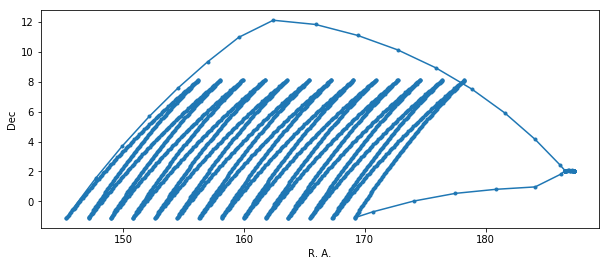

In [8]:
#show the scan route, typically track calibrator + scan sky + track calibrator 
plt.figure(figsize=(10,4))
plt.plot(ra,dec,'.-')
plt.xlabel('R. A.')
plt.ylabel('Dec')
plt.show()

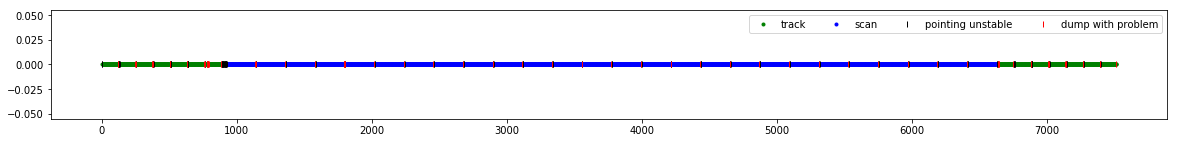

In [9]:
#show time dump label along the scan 
plt.figure(figsize=(20,2))
plt.plot(timestamps[dp_tt]-timestamps[0],np.zeros_like(dp_tt),'g.')
plt.plot(timestamps[dp_ss]-timestamps[0],np.zeros_like(dp_ss),'b.')
plt.plot(timestamps[dp_w]-timestamps[0],np.zeros_like(dp_w),'k|')
plt.plot(timestamps[dp_f]-timestamps[0],np.zeros_like(dp_f),'r|')
plt.legend(['track','scan','pointing unstable','dump with problem'],ncol=4)
plt.show()

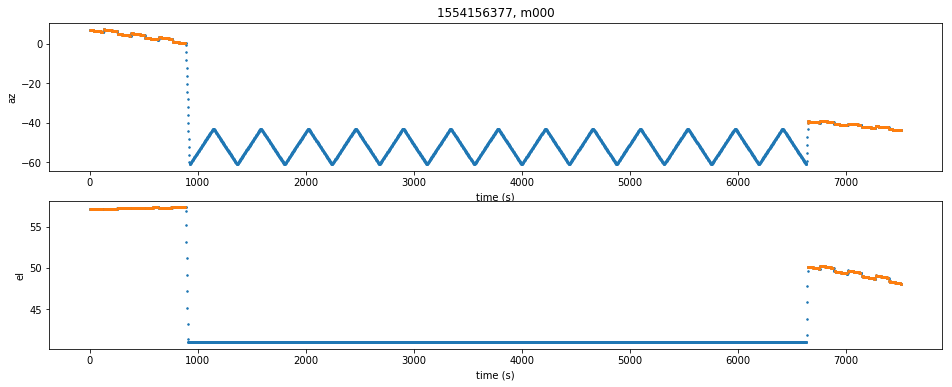

In [10]:
#show the az,el along time
plt.figure(figsize=(16,6))
plt.subplot(211)
if ant not in bad_ants:
    plt.plot(timestamps-timestamps[0],az,'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],az[dp_tt],'.',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('az')
plt.title(str(fname)+', '+str(ant))
plt.subplot(212)
if ant not in bad_ants:
    plt.plot(timestamps-timestamps[0],el,'.',Markersize=3)
    plt.plot(timestamps[dp_tt]-timestamps[0],el[dp_tt],'.',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('el')
#plt.savefig(str(fname)+'_'+str(ant)+'_azel.pdf')
plt.show()

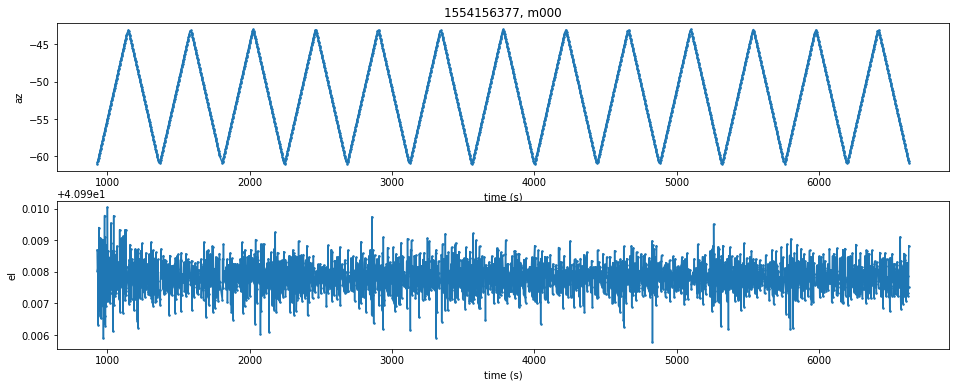

In [11]:
#az,el for scan part, which are expected to be stable
plt.figure(figsize=(16,6))
plt.subplot(211)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],az[dp_ss],'.-',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('az')
plt.title(str(fname)+', '+str(ant))
plt.subplot(212)
if ant not in bad_ants:
    plt.plot(timestamps[dp_ss]-timestamps[0],el[dp_ss],'.-',Markersize=3)
plt.xlabel('time (s)')
plt.ylabel('el')
#plt.savefig(str(fname)+'_'+str(ant)+'_azel.pdf')
plt.show()

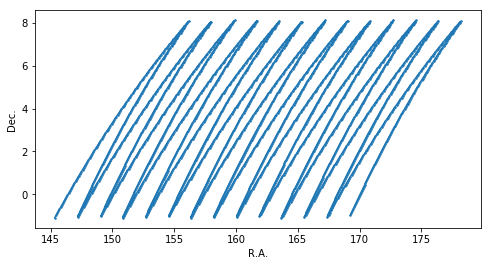

In [12]:
#sky coverage in scan part
plt.figure(figsize=(8,4))
if ant not in bad_ants:
    plt.plot(ra[dp_ss],dec[dp_ss],'.-',Markersize=3)
plt.xlabel('R.A.')
plt.ylabel('Dec.')
plt.show()

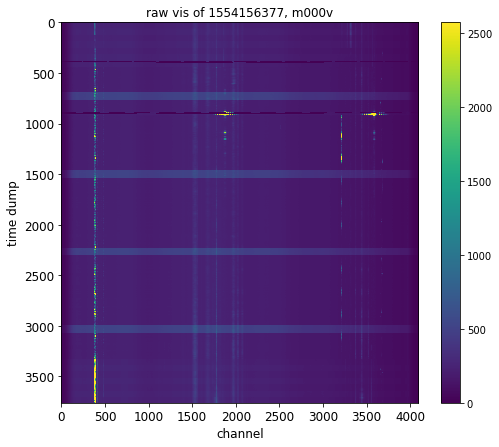

In [13]:
#raw visibility
plt.figure(figsize=(8,7))
plt.imshow(vis,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time dump',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.title('raw vis of '+str(fname)+', '+str(recv),fontsize=12)
plt.colorbar()
#plt.savefig(str(fname)+'_'+str(recv)+'_raw_vis.pdf')
plt.show()

In [14]:
#read noise diode labels in 
t_line=kd.cal_t_line(fname, timestamps,nd_set, nd_cycle, data.dump_period)
#mark,nd_1_det,nd_1a_det,nd_1b_det,lmin,lmax=kd.label_nd_injection(fname,vis, timestamps, dp_ss, data.dump_period)
nd_1a,nd_1b,nd_1,nd_0=kd.call_nd_1_list(fname,timestamps)
nd_s1a,nd_s1b,nd_s1,nd_s0=kd.cal_nds_list(dp_ss,nd_1a,nd_1b,nd_1,nd_0)#dp_ss here, not dp_s
nd_t1a,nd_t1b,nd_t1,nd_t0=kd.cal_ndt_list(dp_tt,nd_1a,nd_1b,nd_1,nd_0)#dp_tt here, not dp_t
nd_labels=nd_s1a,nd_s1b,nd_s1,nd_s0,nd_t1a,nd_t1b,nd_t1,nd_t0
nd_label0=dp_s,dp_t,nd_1a,nd_1b,nd_1,nd_0 ###only for rfi flagging

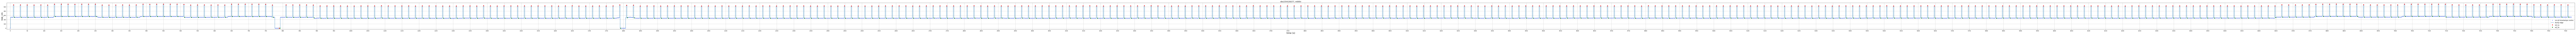

In [15]:
#noise diode injection along time ***plot is very long***
ch_plot0=800
plt.figure(figsize=(np.shape(timestamps)[0]*0.1,4))
plt.plot(timestamps-timestamps[0],(vis[:,ch_plot0]),'b.')
plt.step(timestamps-timestamps[0],(vis[:,ch_plot0]),'-',where='mid')
plt.plot(timestamps[nd_1a]-timestamps[0],(vis[nd_1a,ch_plot0]),'ro')
plt.plot(timestamps[nd_1b]-timestamps[0],(vis[nd_1b,ch_plot0]),'go')
plt.xlabel('time (s)',fontsize=18)
plt.legend(['vis @ timestamps centre','dump edge','nd_1a','nd_1b'],fontsize=12)
plt.ylabel('raw_vis',fontsize=18)
plt.title('obs'+str(fname)+', '+str(recv),fontsize=14)
plt.xlim(-10,timestamps[-1]-timestamps[0]+10)
plt.xticks(np.arange(0,timestamps[-1]-timestamps[0]+1, 50))
plt.grid()
plt.show()

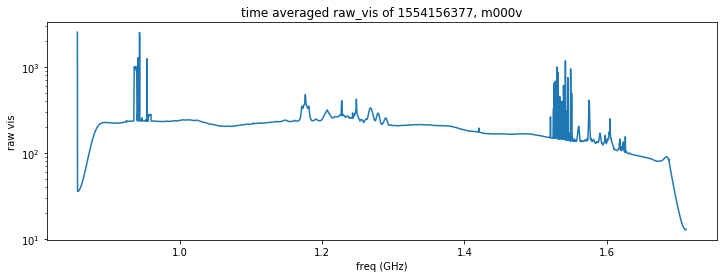

In [16]:
##time mean raw vis to show the bandpass
plt.figure(figsize=(12,4))
plt.plot(freqs/1e9,np.mean(vis[nd_0,:],axis=0))
plt.xlabel('freq (GHz)')
plt.ylabel('raw vis')
plt.yscale('log')
plt.title('time averaged raw_vis of '+str(fname)+', '+str(recv))
plt.show()

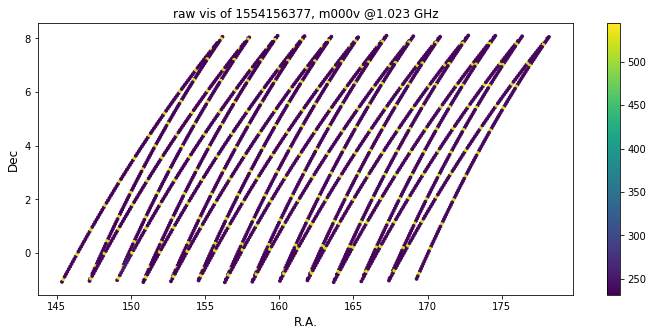

In [17]:
#raw vis map to check diode injection power and period
p_data=vis[dp_ss,ch_plot]
plt.figure(figsize=(12,5))
plt.scatter(ra[dp_ss],dec[dp_ss], c=p_data, vmin=np.min(p_data),vmax=np.max(p_data), s=8)
plt.colorbar()
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
#plt.savefig(str(fname)+'_'+str(recv1)+'_map_scan.pdf')
plt.show()

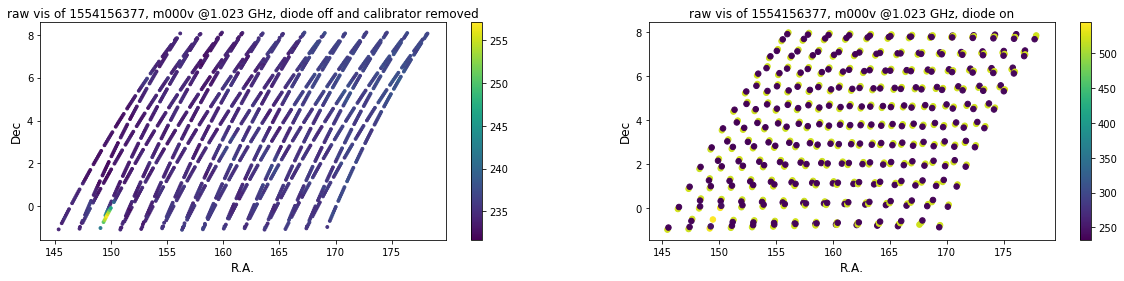

In [18]:
#diode off and diode on parts for above plot
plt.figure(figsize=(20,4))
plt.subplot(121)
p_data=vis[nd_s0,ch_plot]
plt.scatter(ra[nd_s0],dec[nd_s0], c=p_data, vmin=np.min(p_data),vmax=np.max(p_data), s=8)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode off and calibrator removed',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
plt.subplot(122)
p_data=vis[nd_s1,ch_plot]
plt.scatter(ra[nd_s1],dec[nd_s1], c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=30)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode on',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.colorbar()
plt.show()

<type 'numpy.ndarray'>


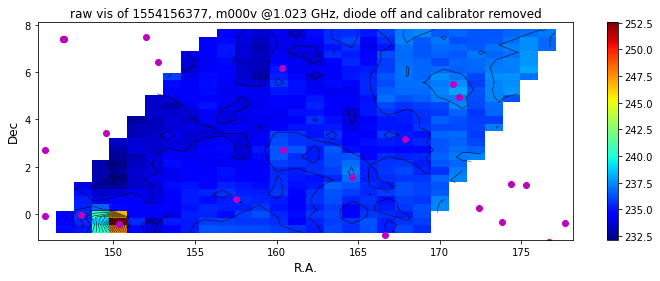

In [19]:
#interpolation map to show the raw vis data vis point sources (magenta dots)
p_data=vis[nd_s0,ch_plot]
plt.figure(figsize=(12,4))
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data)
plt.title('raw vis of '+str(fname)+', '+str(recv)+ ' @'+ str(round(freqs[ch_plot]/1e9,3)) +' GHz, diode off and calibrator removed',fontsize=12)
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.show()

# RFI flagging

## Basic RFI flagging (all channels)

In [20]:
#set the thresholds for SEEK 
First_Thresholds= [30, 50, 40, 60]


In [21]:
#rfi flagging for raw vis data
vis_clean=kr.vis_flag(vis_backup,flags,nd_label0, dp_w, First_Thresholds)

group shape (no flags):
286 286 572 2217 84 84 168 668
### load flags ###
data.flags ratio:
0.0666910915481
###mask data not track/scan###
---------------------------------------------------
###SEEK flagging###
First_Threshold_0, First_Threshold_1, First_Threshold_00, First_Threshold_11= [30, 50, 40, 60]
#flagging scan and nd_0
Std of the non-masked elements of tod is 56.4
Std/Mean of the non-masked elements of tod is 0.32
#flagging scan and nd_1a
Std of the non-masked elements of tod is 125.94
Std/Mean of the non-masked elements of tod is 0.31
#flagging scan and nd_1b
Std of the non-masked elements of tod is 57.11
Std/Mean of the non-masked elements of tod is 0.31
#flagging track and nd_0
Std of the non-masked elements of tod is 61.28
Std/Mean of the non-masked elements of tod is 0.31
#flagging track and nd_1a
Std of the non-masked elements of tod is 127.36
Std/Mean of the non-masked elements of tod is 0.29
#flagging track and nd_1b
Std of the non-masked elements of tod is 66.35
Std/M

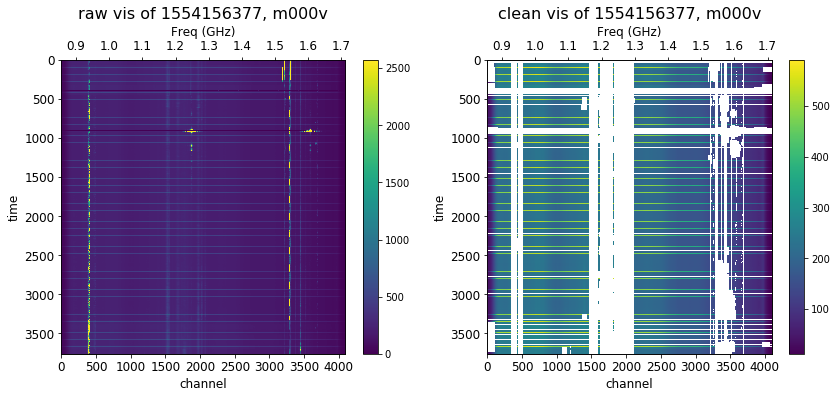

In [22]:
#compare vis before and after rfi flagging

plt.figure(figsize=(14,5.4))
plt.subplot(121)
plt.imshow(vis_backup,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.title('raw vis of '+str(fname)+', '+str(recv),fontsize=16, y=1.12)
plt.colorbar()
plt.twiny()
plt.xticks(fontsize=12)
plt.imshow(vis_backup,aspect='auto',extent=(data.freqs[0]/1e9,data.freqs[-1]/1e9,len(timestamps),0))
plt.xlabel('Freq (GHz)',fontsize=12)
plt.subplot(122)
plt.imshow(vis_clean,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.title('clean vis of '+str(fname)+', '+str(recv),fontsize=16, y=1.12)
plt.colorbar()
plt.twiny()
plt.xticks(fontsize=12)
plt.imshow(vis_clean,aspect='auto',extent=(data.freqs[0]/1e9,data.freqs[-1]/1e9,len(timestamps),0))
plt.xlabel('Freq (GHz)',fontsize=12)
#plt.savefig(str(fname)+'raw_vis.pdf')
plt.show()

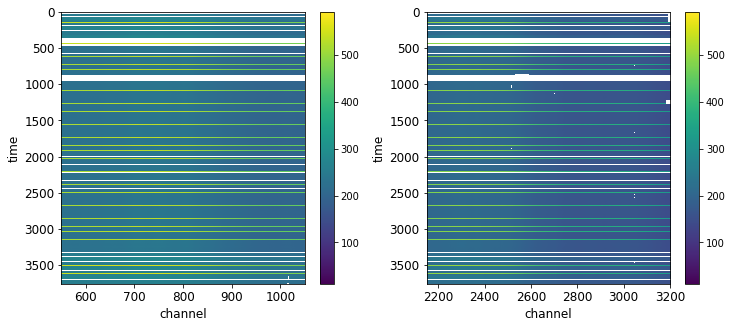

In [23]:
#####to show the part we are intrested (rfi 'free')####
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(vis_clean,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.xlim(550,1050)
plt.colorbar()
plt.subplot(122)
plt.imshow(vis_clean,aspect='auto')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('time',fontsize=12)
plt.xlabel('channel',fontsize=12)
plt.xlim(2150,3200)
plt.colorbar()
plt.show()

In [24]:
vis_clean_old=vis_clean.copy() ###backup


# Multi Channels Calibration 

In [25]:
####prepare for data storage#################
cali_T=np.ma.array(np.zeros_like(vis),mask=True)
Tresi=np.ma.array(np.zeros_like(vis),mask=True)
Tnd_cal=[None for i in range(len(freqs))]
gt_param=[None for i in range(len(freqs))]

In [26]:
for ch_plot in [780,790,800]:##set channels
    print ch_plot
    ################reset param which related to chs ################
    dp_tt,dp_ss,dp_f,dp_t,dp_s=kl.label_dump_1ch(data,ant,pol,flags,ch_plot)
    dp_sb=dp_ss[0]
    dp_se=dp_ss[-1]
    mark,nd_1,nd_1a,nd_1b,lmin,lmax=kd.label_nd_injection(fname,vis, timestamps, dp_ss, data.dump_period)
    nd_1a,nd_1b,nd_1,nd_0=kd.call_nd_1_list(fname,timestamps)
    nd_s1a,nd_s1b,nd_s1,nd_s0=kd.cal_nds_list(dp_ss,nd_1a,nd_1b,nd_1,nd_0)
    nd_t1a,nd_t1b,nd_t1,nd_t0=kd.cal_ndt_list(dp_tt,nd_1a,nd_1b,nd_1,nd_0)
    nd_labels=nd_s1a,nd_s1b,nd_s1,nd_s0,nd_t1a,nd_t1b,nd_t1,nd_t0
    dp_u=kl.cal_dp_u(dp_tt,dp_ss)
    ################################################################
    
    ###aplly the flagging
    vis_clean,nd_s0_clean=kr.vis_flag_1ch(vis_clean,nd_labels,ch_plot)
    #spill model 
    Tspill=km.cal_Tspill(el,pol,freqs, ch_plot,2) #fixed version
    #atmosphere emission model
    Tatmo=km.calc_atmosphere_model_1ch(data,ch_plot)
    #elevation related emission model
    Tel=Tspill+Tatmo 
    #load the diode injection model and get a reference value
    Tnd_std,Tnd_ref,noise,Tnd_spl= km.call_Tnd(data, ant, pol,freqs,ch_plot,0)
    #Galactic model
    nside=64 #healpix nside, 64: Mean Spacing (deg) is 0.9161
    gal=km.cal_Gal_model_np(vis, freqs, ra, dec, ch_plot, ch_plot+1, nside)
    #select beam pattern model
    beam_select='me'
    #BM-III:pattern
    #check pointing stable for track part
    if fname in ['1551055211','1551037708']:
        dp_ca,dp_cb,dp_c0a, dp_c1a,dp_c2a,dp_c3a,dp_c4a,dp_c0b,dp_c1b,dp_c2b,dp_c3b,dp_c4b=kl.cal_dp_c(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg)
    else:
        dp_ca,dp_cb,dp_c0a, dp_c1a,dp_c0b,dp_c1b=kl.cal_dp_c(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg)
    
    #calculate position
    T_ptr2,pattern,pix_label=kb.cal_BMIII(fname,data,ch_plot,ant,pol,flux_model,c0,dp_ca,dp_cb,ang_deg,beam_select)
    x_pix,y_pix,x_pix_max,y_pix_max=pix_label
    #####choose beam model
    T_ptr=T_ptr2 #BM-III 
    #select raw vis for track befor scan
    visa_ptr = vis_clean.copy()
    for i in range(len(timestamps)):
        if i not in dp_ca:
            visa_ptr.mask[i,:]=True
    #show Tgal for track efor scan
    Tgal=gal[:,ch_plot]
    ####set input parameters
    ga0,gb0=ks.cal_gain0(fname,data,ant,pol,flags,ch_plot,dp_tt,dp_ss,ang_deg,T_ptr,vis_clean) #gain level
    Tsys0=10.
    eta_p0=1.0
    func_sm_param0=[Tsys0]
    func_gt_param0=[ga0,0,0,0,0]
    ratio0=0.5
    ####fitting
    instru_pa=ks.solve_params0(timestamps, visa_ptr, ch_plot, nd_ratio, ratio0, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
                          func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
    ####get fitting result
    Tnda=instru_pa[0]
    eta_pa=instru_pa[1]
    sma=instru_pa[2]
    gta=instru_pa[3:-1]
    ratioa=instru_pa[-1]
    print Tnda, eta_pa, ratioa , sma, gta
    #select raw vis for track befor scan
    visb_ptr = vis_clean.copy()
    for i in range(len(timestamps)):
        if i not in dp_cb:
            visb_ptr.mask[i,:]=True
    ####set input parameters
    Tsys0=10.
    eta_p0=1.0
    func_sm_param0=[Tsys0]
    func_gt_param0=[gb0,0,0,0,0]
    ratio0=0.5
    ####fitting######
    instru_pb=ks.solve_params0(timestamps, visb_ptr, ch_plot, nd_ratio, ratio0, T_ptr, eta_p0, Tnd_ref, Tnd_std, Tel, Tgal,
                          func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
    ######get fitting result#####
    Tndb=instru_pb[0]
    eta_pb=instru_pb[1]
    smb=instru_pb[2]
    gtb=instru_pb[3:-1]
    ratiob=instru_pb[-1]
    print Tndb, eta_pb, ratiob , smb, gtb
    ###set input params
    Tnd=(Tnda+Tndb)/2.
    g0=(ga0+gb0)/2.
    Tptr=0 #no point source
    Tsys0=10.
    eta_p0=1.0
    func_sm_param0=[Tsys0,0,0,0]
    func_gt_param0=[g0,0,0,0,0]#must be [-6:-1] from func_obj_sm
    ratio0=0.5
    print Tnd,Tnda,Tndb
    ###raw vis preparsion
    vis_clean_tt=vis_clean.copy()
    vis_clean_tt.mask[:dp_sb,:]=True
    vis_clean_tt.mask[dp_se+1:,:]=True
    ##fitting
    instru_p=ks.solve_params_sm(timestamps, vis_clean_tt, ch_plot, nd_ratio, ratio0, Tptr, eta_p0, Tnd, Tel, Tgal,
                          func_gt_param0, func_sm_param0, nd_0, nd_1a, nd_1b)
    ###output
    eta_p=instru_p[0]
    sm=instru_p[1:-6]
    gt=instru_p[-6:-1] #must be [-5:-1] from func_obj_sm
    ratio=instru_p[-1]
    print eta_p, ratio, sm, gt
    m=ks.calc_total_model_sm(timestamps, nd_ratio, ratio, Tptr, eta_p, Tnd, Tel, Tgal,  gt, sm, nd_0, nd_1a, nd_1b)
    #residual curve
    residual=(vis_clean[:,ch_plot]-m)/ks.func_gt(timestamps,gt)
    print 'resi: '+str(np.mean(residual[nd_s0]))+', '+str(np.std(residual[nd_s0]))
    T=vis_clean[:,ch_plot]/ks.func_gt(timestamps,gt)
    #############save data##################
    cali_T[:,ch_plot]=T
    Tresi[:,ch_plot]=residual
    Tnd_cal[ch_plot]=[Tnda,Tndb]
    gt_param[ch_plot]=gt

780


group shape (with flags):
285 283 568 2189 80 80 160 631
iter=0
l.4028 h
l.4028 v
1.33812408037
deg filter start: 0.70059250214+/-0.0186608774167
deg filter end: 0.700004958613+/-0.000243398539848

deg filter start: 0.000369660982059+/-0.000288915798119
deg filter end: 0.000369660982059+/-0.000288915798119

(3761,) (3761,)
p513_d5_ch4096/p1
129.309163748
p513_d5_ch4096/p1
5.0
/users/jywang/MeerKAT/model_test/beam_model/eidos_sim/p513_d5_ch4096/p1/primary_beam_me_p513_1024channels_5deg_re_part1.fits
/users/jywang/MeerKAT/model_test/beam_model/eidos_sim/p513_d5_ch4096/p1/primary_beam_me_p513_1024channels_5deg_im_part1.fits
(1024, 2, 2, 513, 513)
513
780
1.00105378425 1.00136172727
1.0 1.0
256.0 256.0
(array([255]), array([256]))
255 256
alpha=0.21892182564
deg filter start: 0.70059250214+/-0.0186608774167
deg filter end: 0.700004958613+/-0.000243398539848

deg filter start: 0.000369660982059+/-0.000288915798119
deg filter end: 0.000369660982059+/-0.000288915798119

Optimization terminate

# save data

In [27]:
####call global nd_s0##########################
nd_s1a,nd_s1b,nd_s1,nd_s0=kd.cal_nds_list(dp_s,nd_1a,nd_1b,nd_1,nd_0)#dp_s here, not dp_ss

####save data####
d={}
d['cali_T']=cali_T
d['Tresidual']=Tresi
d['Tnd_cal']=Tnd_cal
d['gt_param']=gt_param
d['nd_s0']=nd_s0

fs=open(str(fname)+'_'+str(recv)+'_cali_data','wb')
pickle.dump(d,fs,protocol=2)
fs.close()


# Some plots

In [28]:
ch1,ch2,ch3=800,790,780

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


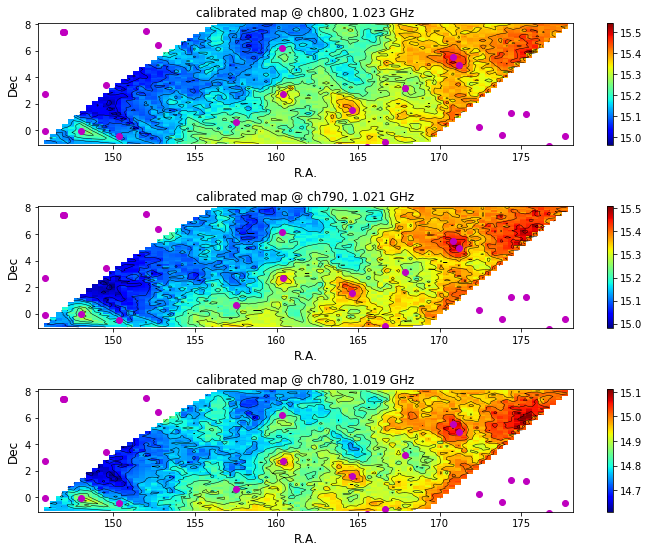

In [29]:
T1=cali_T[:,ch1]
T2=cali_T[:,ch2]
T3=cali_T[:,ch3]

plt.figure(figsize=(12,9))
plt.subplots_adjust(wspace =0, hspace =.5)
plt.subplot(311)
p_data=T1[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('calibrated map @ ch'+str(ch1)+', '+str(round(freqs[ch1]/1e9,3))+' GHz')
plt.subplot(312)
p_data=T2[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('calibrated map @ ch'+str(ch2)+', '+str(round(freqs[ch2]/1e9,3))+' GHz')
plt.subplot(313)
p_data=T3[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('calibrated map @ ch'+str(ch3)+', '+str(round(freqs[ch3]/1e9,3))+' GHz')
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


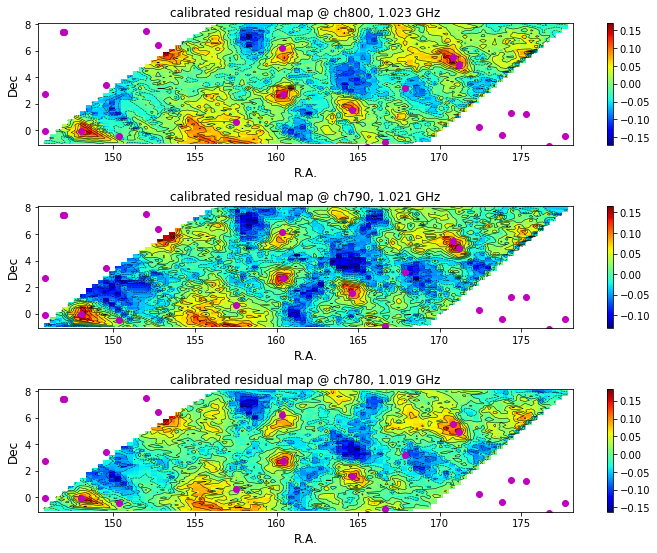

In [30]:
T1=Tresi[:,ch1]
T2=Tresi[:,ch2]
T3=Tresi[:,ch3]

plt.figure(figsize=(12,9))
plt.subplots_adjust(wspace =0, hspace =.5)
plt.subplot(311)
p_data=T1[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('calibrated residual map @ ch'+str(ch1)+', '+str(round(freqs[ch1]/1e9,3))+' GHz')
plt.subplot(312)
p_data=T2[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('calibrated residual map @ ch'+str(ch2)+', '+str(round(freqs[ch2]/1e9,3))+' GHz')
plt.subplot(313)
p_data=T3[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('calibrated residual map @ ch'+str(ch3)+', '+str(round(freqs[ch3]/1e9,3))+' GHz')
plt.show()

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


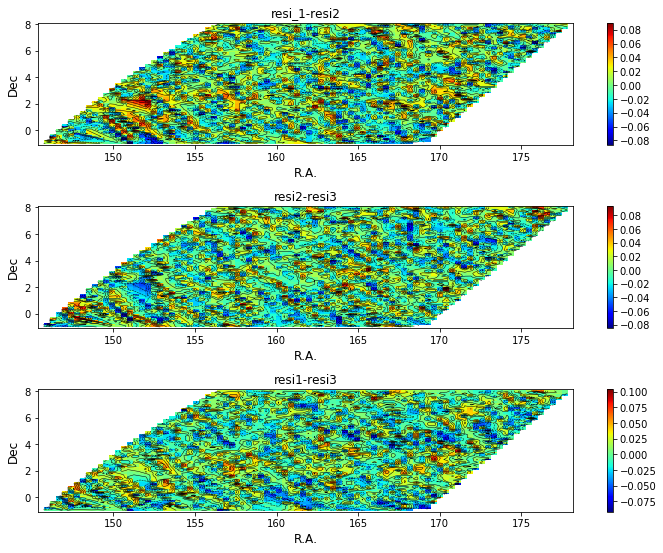

In [31]:
T1=Tresi[:,ch1]-Tresi[:,ch2]
T2=Tresi[:,ch2]-Tresi[:,ch3]
T3=Tresi[:,ch1]-Tresi[:,ch3]

plt.figure(figsize=(12,9))
plt.subplots_adjust(wspace =0, hspace =.5)
plt.subplot(311)
p_data=T1[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
#plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('resi_1-resi2')
plt.subplot(312)
p_data=T2[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
#plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('resi2-resi3')
plt.subplot(313)
p_data=T3[nd_s0]
kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize)
#plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.xlabel('R.A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.title('resi1-resi3')
plt.show()

In [32]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Mon Oct 21 23:51:07 2019#
